# Part 1: Lexicon-Based Sentiment Analysis with VADER

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("Twitter_Data.csv")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.rename(columns={"clean_text": "text"}, inplace=True)
df['category'].unique()

array([-1.,  0.,  1.])

In [2]:
import re
from nltk.stem.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

stemmer = PorterStemmer() # stemmer
def stemming(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

def preprocess(text):
    emojis = r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+"  # regex for emojis
    html = r'http\S+|www\S+' # regex for urls
    mentions = r"@\w+" # regex for mentions
    hashtags = r"#" # regex for hashtags
    text = text.lower() # convert to lowercase
    text = re.sub(f'{emojis}|{html}|{mentions}|{hashtags}','',text) # remove emojis, urls, mentions and hashtags
    text = remove_stopwords(text) # remove stopwords
    text = stemming(text)
    return text

df["clean_text"] = df["text"].apply(preprocess)

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, padding='post')

In [4]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return 1
    elif score <= -0.05:
        return -1
    else:
        return 0
df["predicted"] = df["clean_text"].apply(get_sentiment)
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,category,clean_text,predicted
0,when modi promised “minimum government maximum...,-1.0,modi promis “minimum govern maximum governance...,-1
1,talk all the nonsense and continue all the dra...,0.0,talk nonsens continu drama vote modi,0
2,what did just say vote for modi welcome bjp t...,1.0,vote modi welcom bjp told rahul main campaign ...,1
3,asking his supporters prefix chowkidar their n...,1.0,ask support prefix chowkidar name modi great s...,1
4,answer who among these the most powerful world...,1.0,answer power world leader today trump putin modi,0


In [5]:
from sklearn.metrics import classification_report
print(classification_report(df["category"], df["predicted"]))

              precision    recall  f1-score   support

        -1.0       0.42      0.56      0.48     35509
         0.0       0.58      0.53      0.55     55211
         1.0       0.67      0.61      0.63     72249

    accuracy                           0.57    162969
   macro avg       0.56      0.56      0.56    162969
weighted avg       0.58      0.57      0.57    162969



# Baseline RNN Model

In [11]:
df["category_cat"] = df["category"].copy()
df["category_cat"][df["category"] == -1] = 0
df["category_cat"][df["category"] == 0] = 1
df["category_cat"][df["category"] == 1] = 2

C:\Users\ahmad\AppData\Local\Temp\ipykernel_28384\38674933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["category_cat"][df["category"] == -1] = 0
C:\Users\ahmad\AppData\Local\Temp\ipykernel_28384\38674933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["category_cat"][df["category"] == 0] = 1
C:\Users\ahmad\AppData\Local\Temp\ipykernel_28384\38674933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["category_cat"

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight


X_train, X_test, y_train, y_test = train_test_split(padded_sequences,
                                                    df['category_cat'].astype(int),
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['category_cat'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
y_train = y_train.to_numpy().reshape(-1,1)

class_weights_dict = dict(zip(np.unique(y_train), class_weights))

sample_weights = np.zeros(len(y_train))
for i in range(len(y_train)):
    sample_weights[i] = class_weights_dict[y_train[i][0]]

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

# Monitor
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Save best Model
checkpoint_path = 'Weights/best_rnn_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max', 
    save_best_only=True,
    verbose=0)

# Reduce Learning Rate on Validation set accuracy reduction
lr_reduce_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    min_delta=1e-3,
    cooldown=2,
    min_lr=1e-8,
    verbose=0)

# # Early Stopping
# early_stopping_callback = EarlyStopping(
#     monitor='loss',
#     min_delta=1e-3,
#     patience=5,
#     verbose=0
# )
# keras tdqm
from tqdm.keras import TqdmCallback

In [24]:
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(SimpleRNN(128, dropout=0.3))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=1e-3, clipvalue=1.0)
model.compile(  loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'],
                )

history = None
try:
    history = model.fit(X_train, y_train,
                epochs=25,
                verbose=0,
                batch_size=64,
                validation_data=(X_test, y_test),
                sample_weight=sample_weights,
                callbacks=[ lr_reduce_callback,
                            checkpoint_callback,
                            tensorboard_callback,
                            TqdmCallback(verbose=1),
                            ])
except KeyboardInterrupt:
    print("Manually Interruptted")
    
if history:
    pd.DataFrame(history.history).to_csv("History/history_rnn.csv")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

# LSTM Model

In [25]:
from tensorflow.keras.layers import LSTM


model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.3))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
# Save best Model
checkpoint_path = 'Weights/best_lstm_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max', 
    save_best_only=True,
    verbose=0)

optimizer = Adam(learning_rate=1e-3, clipvalue=1.0)
model.compile(  loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'],
                )

history = None
try:
    history = model.fit(X_train, y_train,
                epochs=25,
                verbose=0,
                batch_size=32,
                validation_data=(X_test, y_test),
                sample_weight=sample_weights,
                callbacks=[ lr_reduce_callback,
                            checkpoint_callback,
                            tensorboard_callback,
                            TqdmCallback(verbose=1),
                            ] )
except KeyboardInterrupt:
    print("Manually Interruptted")
    
    
if history:
    pd.DataFrame(history.history).to_csv("History/history_lstm.csv")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

# GRU Model

In [26]:
from tensorflow.keras.layers import GRU


model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(GRU(128, dropout=0.3))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
# Save best Model
checkpoint_path = 'Weights/best_gru_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max', 
    save_best_only=True,
    verbose=0)

optimizer = Adam(learning_rate=1e-3, clipvalue=1.0)
model.compile(  loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'],
                )

history = None
try:
    history = model.fit(X_train, y_train,
                epochs=25,
                verbose=0,
                batch_size=32,
                validation_data=(X_test, y_test),
                sample_weight=sample_weights,
                callbacks=[ lr_reduce_callback,
                            checkpoint_callback,
                            tensorboard_callback,
                            TqdmCallback(verbose=1),
    
                            ] )
except KeyboardInterrupt:
    print("Manually Interruptted")
    
    
if history:
    pd.DataFrame(history.history).to_csv("History/history_gru.csv")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [27]:
from tensorflow.keras.models import load_model
model_gru = load_model('Weights/best_gru_model.keras')
model_lstm = load_model('Weights/best_lstm_model.keras')
model_rnn = load_model('Weights/best_rnn_model.keras')

In [32]:
from sklearn.metrics import f1_score

# comparison
evals = []
models = [model_gru, model_lstm, model_rnn]
for model in models:
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=1)  # Convert softmax output to class indices

    f1 = f1_score(y_test, y_pred, average='macro')  # Macro-averaged F1-score for 3 classes

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    evals.append([loss, acc, f1])

evals = pd.DataFrame(evals, columns=['loss', 'accuracy', 'f1'])
evals.index = ['GRU', 'LSTM', 'RNN']
evals

,loss,accuracy,f1
GRU,1.095619,0.443333,0.204773
LSTM,0.499106,0.824385,0.817504
RNN,0.584859,0.796005,0.787716


# GRU had small score cuz of dropout rate

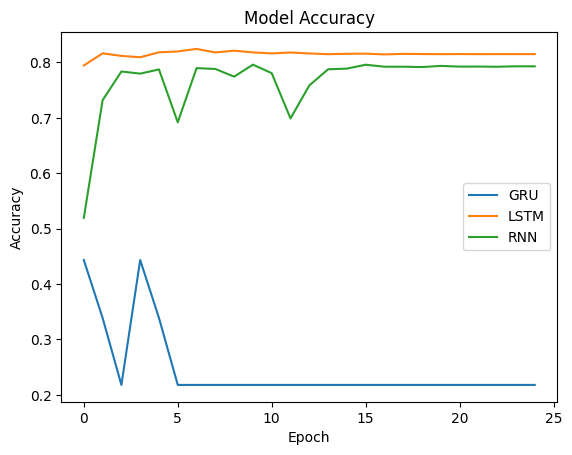

In [33]:
history_gru = pd.read_csv("History/history_gru.csv")
history_lstm = pd.read_csv("History/history_lstm.csv")
history_rnn = pd.read_csv("History/history_rnn.csv")
# plotting
import matplotlib.pyplot as plt
plt.plot(history_gru['val_accuracy'])
plt.plot(history_lstm['val_accuracy'])
plt.plot(history_rnn['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GRU', 'LSTM', 'RNN'])
plt.show()

### Comparison of VADER vs. RNN/GRU/LSTM for Sentiment Analysis  

| Feature                 | VADER                      | RNN/GRU/LSTM (Deep Learning) |
|-------------------------|---------------------------|-----------------------------|
| **Interpretability**    | ✅ **Highly interpretable** – Uses word lexicons with clear rules. | ❌ **Low interpretability** – Complex learned representations make it hard to explain. |
| **Computational Requirements** | ✅ **Very low** – Rule-based, fast even on large datasets. | ❌ **High** – Requires significant compute power for training and inference. |
| **Handling Context/Sarcasm** | ❌ **Poor** – Does not handle context, sarcasm, or nuanced language well. | ✅ **Better** – Can learn contextual relationships and detect subtle sentiment shifts. |
| **Need for Labeled Data** | ❌ **No labeled data required** – Prebuilt lexicon-based approach. | ✅ **Requires labeled data** – Needs annotated datasets for supervised learning. |

Why might LSTM-based models struggle with short texts (e.g., tweets) compared to VADER?

- Becuase lstms need to carry context for long sequences, so words at the start might not get carried to the end
- While Vader just add all the scores of each single word 

When would you prefer a lexicon-based approach over a neural network?
- I think when I have small power or resources, as lexicon-based are memory based, while NNs need computation.

1019/1019 [==============================] - 4s 4ms/step


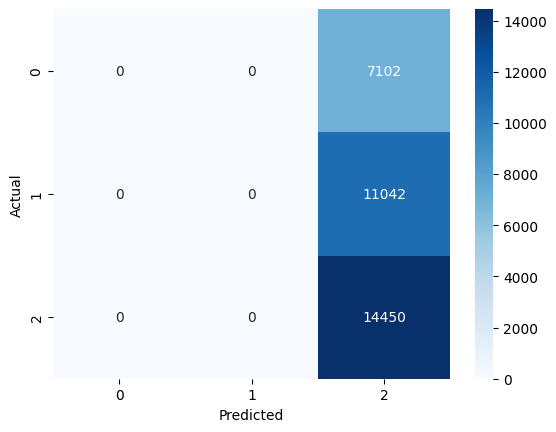

1019/1019 [==============================] - 4s 4ms/step


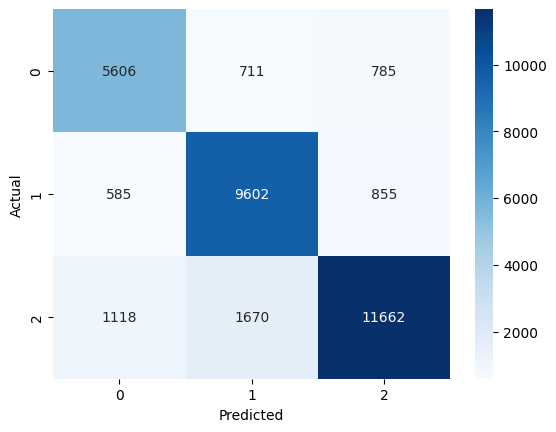

1019/1019 [==============================] - 8s 8ms/step


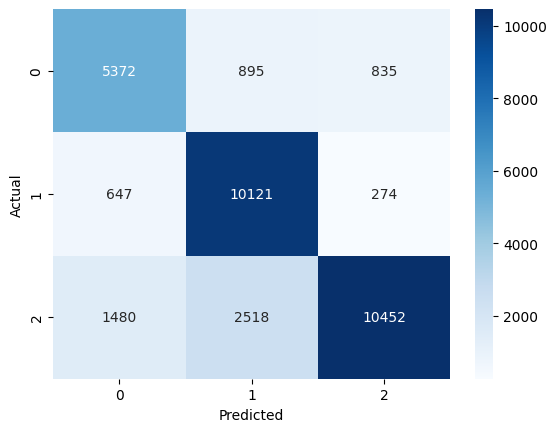

In [35]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
# Create heatmap for confusion matrix
for model in models:
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=1)  # Convert softmax output to class indices
    cm = confusion_matrix(y_test, y_pred)
    heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()